# Loading libraries and data

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy import stats
from tqdm.auto import tqdm, trange
from networkx.algorithms import bipartite

In [2]:
g = nx.read_gexf('../graph.gexf')

# Preprocessing

## Removing super-mods 

Let's try to identify supermods. Even if they aren't bots, they moderate so many subs that they can't possibly pay attention to all of them. Edges due to them aren't meaningful.

In [3]:
mod_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0}

In [4]:
n_moderated = [len(g.edges(n)) for n in mod_nodes]

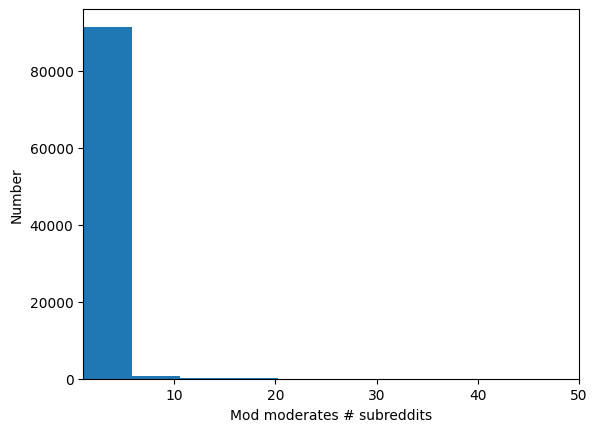

In [5]:
plt.hist(n_moderated, bins=50)
plt.xlim([1, 50])
plt.xlabel("Mod moderates # subreddits")
plt.ylabel("Number");

In [6]:
stats.percentileofscore(n_moderated, 15)

99.77130281880063

By removing all moderators that moderate > 15 subs, we'd only be removing 0.23% of all moderators, but 79.2% of all edges.

In [7]:
mods_to_remove = {n for n in mod_nodes if len(g.edges(n)) > 15}
g.remove_nodes_from(mods_to_remove)

Removing edges has split our graph into isolated connected components.

In [8]:
isolates = list(nx.connected_components(g))
len(isolates)

11802

In [9]:
isolates_size = sorted([len(iso) // 2 for iso in isolates], reverse=True)
isolates_size[0], isolates_size[1], sum(isolates_size[2:])

(30183, 47, 26215)

So we have 11'802 components. Of these, there is one giant component of 30'183 subs, and other smaller components comprising in total 26'262 subs.

## Computing edge conductivity

We also compute edge conductivity, where the conductivity of an edge is equal to $1/(\text{\# subs that this mod moderates})$. We will use this metric later on to compute [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance).

In [10]:
edge_conductivity = dict()
sub_n_members = nx.get_node_attributes(g, "size")
for mod, sub in g.edges:
    edge_conductivity[(mod, sub)] = 1 / len(g.edges(mod))

In [11]:
nx.set_edge_attributes(g, edge_conductivity, 'conductivity')

# Exploration

My strategy is as follows. I will be using [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance) to rank subs in order of relevance.

However, computing the resistance distance is slow, so instead of running it on the whole graph, I will select a group of nodes around my subreddit of interest (aka the **locality**). I will then rank those candidates using the resistance distance as a metric.

In [42]:
def get_locality(path_lengths, s0, max_loc_size):
    #increasing maximum path length from s0 to nodes until I reach my desired locality size
    max_length = 0
    curr_locality = [s0]
    next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]
    
    while len(next_locality) < max_loc_size and len(next_locality) < len(path_lengths):
        max_length += 1
        curr_locality = next_locality
        next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]

    return curr_locality

## Bipartite Graph

Let's explore an interesting subreddit called [r/hebrew](https://www.reddit.com/r/hebrew).

In [21]:
s0 = 'hebrew'

In [22]:
path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

In [23]:
#a subgraph covering our locality
g_local = g.subgraph(locality)

In [24]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 1min 23s, sys: 23.5 s, total: 1min 47s
Wall time: 14.9 s


Now let's select the nodes.

In [25]:
mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

Because `sorted` is a stable sort, we can priorize nodes by degree of separation, while sort nodes within each "shell" using the resistance distance.

In [26]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-15
candidate_subs = candidate_subs[:15]

In [19]:
candidate_mods = list()
for mod in mod_nodes:
    inter = set(g.neighbors(mod)) &  set(candidate_subs)
    if len(inter) > 1:
        candidate_mods.append(mod)

We next write out our graph and visualise it in Gephi.

In [21]:
candidate_nodes = candidate_subs + candidate_mods
nx.write_gexf(g_local.subgraph(candidate_nodes), 'example-bipartite.gexf')

The result:

<div>
<img src="example-bipartite.png" width="700"/>
</div>

## Projected Graph

We can also project the bipartite graph, and display only subreddits, while omitting the mods.

In [47]:
s0 = 'Palestine'

path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

#a subgraph covering our locality
g_local = g.subgraph(locality)

mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

In [41]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 19.8 s, sys: 7.88 s, total: 27.7 s
Wall time: 3.92 s


In [46]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-30
candidate_subs = candidate_subs[:30]

In [49]:
#projecting graph onto subreddits
g_local_subs = bipartite.weighted_projected_graph(g_local, sub_nodes)

In [51]:
nx.write_gexf(g_local_subs.subgraph(candidate_subs), 'example-projected.gexf')

The result, visualised in Gephi:

<div>
<img src="example-projected.png" width="800"/>
</div>